Dataset downloaded to: /root/.cache/kagglehub/datasets/rhythmroy/sen12flood-flood-detection-dataset/versions/1
['SEN12FLOOD']
['0276', '0085', '9', '0278', '0100', '0168', '0155', '0321', '0316', '0184', '0225', '0150', '13', '0222', '0238', '59', '0209', '0148', '56', '0139', '0055', '0027', '0014', '4', '0258', '0245', '0116', '0174', '24', '0122', '0204', '0266', '0074', '0275', '0009', '0298', '0213', '0300', '44', '0066', '65', '0095', '0286', '0311', '0318', '0255', '20', '0324', '0145', '0077', '0181', '0299', '0159', '0304', '0249', '0223', '0267', '61', '0246', '0259', '0091', '0221', '0026', '0309', '0157', '0068', '66', '0086', '0306', '21', '0107', '0232', '0191', '0034', 'S1list.json', '0288', '0273', '0146', '60', '0208', '53', '10', '0178', '0108', '26', '0331', '0333', '0279', '0177', '3', '35', '0160', '0021', '0080', '62', '0057', '0320', '45', '0219', '0011', '0072', '37', '0022', '46', '0135', '42', '0192', '0263', '0031', '0130', '0240', '0048', '16', '18', '17', '

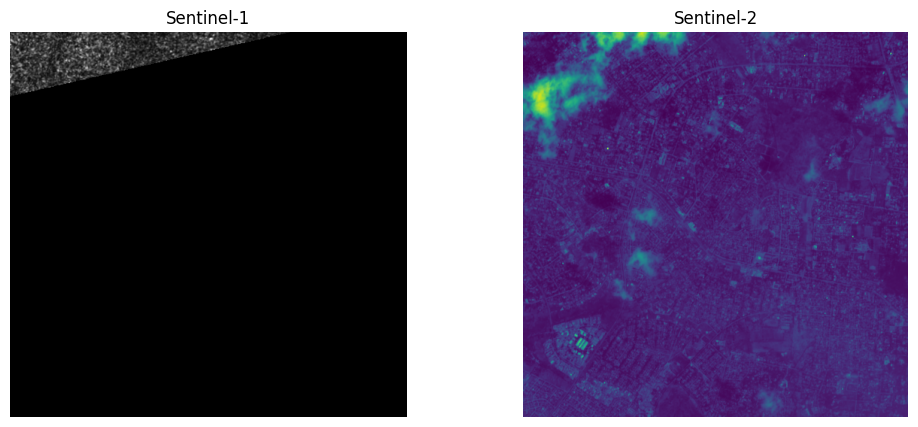

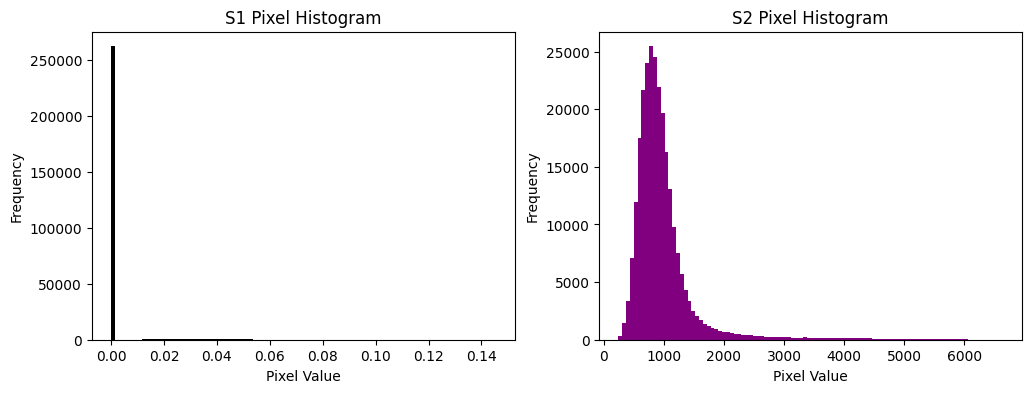

✅ Done! Displayed images + histograms.


In [ ]:
!pip install rasterio

import pandas as pd
import numpy as np
import os
import kagglehub
import rasterio
import matplotlib.pyplot as plt
import random
import glob

path = kagglehub.dataset_download("rhythmroy/sen12flood-flood-detection-dataset")
print("Dataset downloaded to:", path)

print(os.listdir(path))

root = os.path.join(path, "SEN12FLOOD")
print(os.listdir(root))

all_s1_files = []
all_s2_files = []

scene_dirs = [os.path.join(root, d) for d in os.listdir(root) if d.isdigit() and os.path.isdir(os.path.join(root, d))]
scene_dirs.sort()

for scene_dir in scene_dirs:
    tif_files_in_scene = glob.glob(os.path.join(scene_dir, "*.tif"))
    all_s1_files.extend([f for f in tif_files_in_scene if "S1" in os.path.basename(f)])
    all_s2_files.extend([f for f in tif_files_in_scene if "S2" in os.path.basename(f)])


s1_files = sorted(all_s1_files)
s2_files = sorted(all_s2_files)

print("S1 files:", len(s1_files))
print("S2 files:", len(s2_files))


idx = random.randint(0, len(s1_files)-1)
print("Random tile index:", idx)

with rasterio.open(s1_files[idx]) as f:
  s1_img = f.read(1)

with rasterio.open(s2_files[idx]) as f:
  s2_img = f.read(1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Sentinel-1")
plt.imshow(s1_img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Sentinel-2")
plt.imshow(s2_img, cmap="viridis")
plt.axis("off")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(s1_img.flatten(), bins=100, color="black")
plt.title("S1 Pixel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(s2_img.flatten(), bins=100, color="purple")
plt.title("S2 Pixel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print("✅ Done! Displayed images + histograms.")

In [ ]:
import os, random, numpy as np, rasterio

def check_outliers_in_tile(path):
    fname = os.path.basename(path).upper()
    try:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)

            # S2 optical: integer reflectance -> normalize to [0,1]
            if fname.startswith("S2"):
                if arr.max() > 100:        # heuristic: unnormalized
                    arr = arr / 10000.0
                min_thr, max_thr = 0.0, 1.0

            # S1 SAR: already float backscatter, allow a wider valid range
            elif fname.startswith(("S1")):
                min_thr, max_thr = 0.0, 1.5   # based on observed stats

            else:
                # Unknown type: skip
                return None

            total = arr.size
            low  = np.sum(arr < min_thr)
            high = np.sum(arr > max_thr)
            return (low + high) / total * 100.0

    except Exception as e:
        print("⚠️ Error reading:", path, "->", e)
        return None

valid_files = s1_files + s2_files

# Re-run on a subset
sample_paths = random.sample(valid_files, 200)

outlier_stats = [check_outliers_in_tile(p) for p in sample_paths]
valid_outlier_stats = [x for x in outlier_stats if x is not None]

print(f"Average % of outlier pixels per tile: {np.mean(valid_outlier_stats):.4f}%")
print(f"Max % of outlier pixels in any tile: {np.max(valid_outlier_stats):.4f}%")

Average % of outlier pixels per tile: 0.3415%
Max % of outlier pixels in any tile: 26.9481%


In [ ]:
import pandas as pd

# Suppose you made a DataFrame of your TIFF file paths
df = pd.DataFrame(valid_files, columns=["path"])

# Check for missing or invalid entries
print("Missing values per column:")
print(df.isna().sum()[df.isna().sum() > 0])

# Drop any empty or missing path rows (should be 0 ideally)
df = df.dropna(subset=["path"])
df = df[df["path"].apply(os.path.exists)].reset_index(drop=True)

# Confirm it's clean
print("✅ Remaining missing values after cleanup:")
print(df.isna().sum()[df.isna().sum() > 0])

Missing values per column:
Series([], dtype: int64)
✅ Remaining missing values after cleanup:
Series([], dtype: int64)


In [ ]:
# Check how many missing values per column
print("Missing values per column:")
print(df.isnull().sum())

# Optional: Drop columns with too many missing values (e.g., >50%)
threshold = len(df) * 0.5
cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > threshold]

if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"🗑️ Dropped columns with >50% missing data: {cols_to_drop}")
else:
    print("✅ No columns with excessive missing data.")

Missing values per column:
path    0
dtype: int64
✅ No columns with excessive missing data.


In [ ]:
!ls -R /root/.cache/kagglehub/datasets/

Streaming output truncated to the last 5000 lines.
S2_2019-04-08_B12.tif
S2_2019-04-08_B8A.tif
S2_2019-04-21_B01.tif
S2_2019-04-21_B02.tif
S2_2019-04-21_B03.tif
S2_2019-04-21_B04.tif
S2_2019-04-21_B05.tif
S2_2019-04-21_B06.tif
S2_2019-04-21_B07.tif
S2_2019-04-21_B08.tif
S2_2019-04-21_B09.tif
S2_2019-04-21_B11.tif
S2_2019-04-21_B12.tif
S2_2019-04-21_B8A.tif
S2_2019-04-23_B01.tif
S2_2019-04-23_B02.tif
S2_2019-04-23_B03.tif
S2_2019-04-23_B04.tif
S2_2019-04-23_B05.tif
S2_2019-04-23_B06.tif
S2_2019-04-23_B07.tif
S2_2019-04-23_B08.tif
S2_2019-04-23_B09.tif
S2_2019-04-23_B11.tif
S2_2019-04-23_B12.tif
S2_2019-04-23_B8A.tif

/root/.cache/kagglehub/datasets/rhythmroy/sen12flood-flood-detection-dataset/versions/1/SEN12FLOOD/28:
S1A_IW_GRDH_1SDV_20181217T181826_20181217T181851_025069_02C42B_6B4A_corrected_VH.tif
S1A_IW_GRDH_1SDV_20181217T181826_20181217T181851_025069_02C42B_6B4A_corrected_VV.tif
S1A_IW_GRDH_1SDV_20181229T181825_20181229T181850_025244_02CA84_6502_corrected_VH.tif
S1A_IW_GRDH_1SDV_2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

!mkdir -p /content/drive/MyDrive/cleaned_SEN12
!cp -r /root/.cache/kagglehub/datasets/ /content/drive/MyDrive/cleaned_SEN12/
!ls /content/drive/MyDrive/cleaned_SEN12/

#!cp -r /root/.cache/kagglehub/datasets/ /content/drive/MyDrive/cleaned_SEN12/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
datasets


In [ ]:
#!ls /content/drive/MyDrive/cleaned_SEN12/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np

def normalize_image_percentile(img, low=2, high=98):
    """
    Normalize an image using percentiles.
    Works for (C,H,W) or (H,W).
    """
    img = img.astype(np.float32)

    if img.ndim == 3:
        normalized = np.zeros_like(img, dtype=np.float32)
        for c in range(img.shape[0]):
            band = img[c]
            p_low = np.percentile(band, low)
            p_high = np.percentile(band, high)
            normalized[c] = np.clip((band - p_low) / (p_high - p_low + 1e-6), 0, 1)
        return normalized

    else:
        p_low = np.percentile(img, low)
        p_high = np.percentile(img, high)
        return np.clip((img - p_low) / (p_high - p_low + 1e-6), 0, 1)

In [ ]:
def prepare_mask(mask):
    mask = (mask > 0).astype(np.uint8)
    return mask

In [ ]:
def minmax_normalize(img):
    img = img.astype(np.float32)
    min_val = img.min()
    max_val = img.max()
    return (img - min_val) / (max_val - min_val + 1e-6)

In [ ]:
def normalize_percentile(img, low=2, high=98):
    img = img.astype(np.float32)
    p_low = np.percentile(img, low)
    p_high = np.percentile(img, high)
    return np.clip((img - p_low) / (p_high - p_low + 1e-6), 0, 1)

In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("rhythmroy/sen12flood-flood-detection-dataset")
dataset_path

Using Colab cache for faster access to the 'sen12flood-flood-detection-dataset' dataset.


'/kaggle/input/sen12flood-flood-detection-dataset'

In [ ]:
!ls -R /kaggle/input/sen12flood-flood-detection-dataset

Streaming output truncated to the last 5000 lines.
S2_2019-04-08_B12.tif
S2_2019-04-08_B8A.tif
S2_2019-04-21_B01.tif
S2_2019-04-21_B02.tif
S2_2019-04-21_B03.tif
S2_2019-04-21_B04.tif
S2_2019-04-21_B05.tif
S2_2019-04-21_B06.tif
S2_2019-04-21_B07.tif
S2_2019-04-21_B08.tif
S2_2019-04-21_B09.tif
S2_2019-04-21_B11.tif
S2_2019-04-21_B12.tif
S2_2019-04-21_B8A.tif
S2_2019-04-23_B01.tif
S2_2019-04-23_B02.tif
S2_2019-04-23_B03.tif
S2_2019-04-23_B04.tif
S2_2019-04-23_B05.tif
S2_2019-04-23_B06.tif
S2_2019-04-23_B07.tif
S2_2019-04-23_B08.tif
S2_2019-04-23_B09.tif
S2_2019-04-23_B11.tif
S2_2019-04-23_B12.tif
S2_2019-04-23_B8A.tif

/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/28:
S1A_IW_GRDH_1SDV_20181217T181826_20181217T181851_025069_02C42B_6B4A_corrected_VH.tif
S1A_IW_GRDH_1SDV_20181217T181826_20181217T181851_025069_02C42B_6B4A_corrected_VV.tif
S1A_IW_GRDH_1SDV_20181229T181825_20181229T181850_025244_02CA84_6502_corrected_VH.tif
S1A_IW_GRDH_1SDV_20181229T181825_20181229T181850_025244_0

In [ ]:
!find /kaggle/input/sen12flood-flood-detection-dataset -type f -iname "*mask*" -or -iname "*label*" -or -iname "*flood*"

/kaggle/input/sen12flood-flood-detection-dataset
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD


In [ ]:
import kagglehub
import os

dataset_path = kagglehub.dataset_download("rhythmroy/sen12flood-flood-detection-dataset")
DATA_DIR = os.path.join(dataset_path, "SEN12FLOOD")
print("DATA_DIR =", DATA_DIR)

Using Colab cache for faster access to the 'sen12flood-flood-detection-dataset' dataset.
DATA_DIR = /kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD


In [ ]:
import rasterio
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm
import re
from rasterio.enums import Resampling

# -----------------------------
# PATHS
# -----------------------------
DATA_DIR = "/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD"
OUTPUT_DIR = "/kaggle/working/flood_masks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# HELPERS TO LOAD + RESIZE
# -----------------------------
def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype(np.float32), src.profile

def resize_array(array, profile, target_shape):
    """Resize a raster array to target_shape using bilinear interpolation."""
    t_h, t_w = target_shape
    with rasterio.io.MemoryFile() as memfile:
        profile = profile.copy()
        profile.update(height=array.shape[0], width=array.shape[1])
        with memfile.open(**profile) as dataset:
            dataset.write(array, 1)
        with memfile.open() as dataset:
            data = dataset.read(
                out_shape=(1, t_h, t_w),
                resampling=Resampling.bilinear
            )[0]
    return data

# -----------------------------
# NDWI FROM SENTINEL-2
# -----------------------------
def compute_ndwi(b03_path, b08_path):
    g, g_prof = load_band(b03_path)
    nir, nir_prof = load_band(b08_path)

    # Resize NIR to match Green if needed
    if g.shape != nir.shape:
        nir = resize_array(nir, nir_prof, g.shape)

    ndwi = (g - nir) / (g + nir + 1e-6)
    return ndwi, g_prof

# -----------------------------
# SAR VH DROP
# -----------------------------
def compute_vh_drop(vh_pre_path, vh_post_path):
    vh_pre, pre_prof = load_band(vh_pre_path)
    vh_post, post_prof = load_band(vh_post_path)

    # Resize pre-flood VH to match post-flood VH
    if vh_pre.shape != vh_post.shape:
        vh_pre = resize_array(vh_pre, pre_prof, vh_post.shape)

    vh_drop = vh_post - vh_pre
    return vh_drop, post_prof

# -----------------------------
# LOAD ALL TIFS
# -----------------------------
all_tifs = glob.glob(os.path.join(DATA_DIR, "**/*.tif"), recursive=True)
df = pd.DataFrame({"path": all_tifs})

# -----------------------------
# TILE + TIMESTAMP
# -----------------------------
def extract_tile(path):
    return path.split("/")[-2]

def extract_timestamp(path):
    if "S2_" in path:
        m = re.search(r"S2_(\d{4}-\d{2}-\d{2})", path)
        return m.group(1) if m else None
    m = re.search(r"_((20\d{2})(\d{2})(\d{2}))T", path)
    if m:
        return f"{m.group(2)}-{m.group(3)}-{m.group(4)}"
    return None

df["tile"] = df["path"].apply(extract_tile)
df["timestamp"] = df["path"].apply(extract_timestamp)
df = df.dropna(subset=["timestamp"])

# -----------------------------
# GENERATE MASKS
# -----------------------------
generated_masks = []

for tile in tqdm(df["tile"].unique()):
    subset = df[df["tile"] == tile]

    # S2 Green and NIR
    b03 = subset[subset["path"].str.contains("B03")]
    b08 = subset[subset["path"].str.contains("B08")]
    if len(b03) == 0 or len(b08) == 0:
        continue

    pre_date = subset["timestamp"].min()
    post_date = subset["timestamp"].max()

    vh_pre = subset[(subset["timestamp"] == pre_date) & (subset["path"].str.contains("_VH"))]
    vh_post = subset[(subset["timestamp"] == post_date) & (subset["path"].str.contains("_VH"))]
    if len(vh_pre) == 0 or len(vh_post) == 0:
        continue

    b03_path = b03.iloc[0]["path"]
    b08_path = b08.iloc[0]["path"]
    vh_pre_path = vh_pre.iloc[0]["path"]
    vh_post_path = vh_post.iloc[0]["path"]

    # NDWI
    ndwi, ndwi_prof = compute_ndwi(b03_path, b08_path)
    ndwi_mask = (ndwi > 0.3).astype(np.uint8)

    # VH DROP
    vh_drop, vh_prof = compute_vh_drop(vh_pre_path, vh_post_path)
    vh_mask = (vh_drop < -2.0).astype(np.uint8)

    # -----------------------------------------
    # ALIGN MASK SHAPES (IMPORTANT!)
    # -----------------------------------------
    if ndwi_mask.shape != vh_mask.shape:
        vh_mask = resize_array(vh_mask, vh_prof, ndwi_mask.shape)

    combined = np.maximum(ndwi_mask, vh_mask)

    out_path = os.path.join(OUTPUT_DIR, f"{tile}_mask.tif")

    # Save mask
    meta = ndwi_prof.copy()
    meta.update({"count": 1, "dtype": "uint8", "height": combined.shape[0], "width": combined.shape[1]})

    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(combined, 1)

    generated_masks.append(out_path)

len(generated_masks)


100%|██████████| 335/335 [00:10<00:00, 33.01it/s]


81

In [ ]:
!ls -R /kaggle/working/flood_masks | head -n 20

/kaggle/working/flood_masks:
0026_mask.tif
0027_mask.tif
0059_mask.tif
0060_mask.tif
0061_mask.tif
0063_mask.tif
0065_mask.tif
0066_mask.tif
0067_mask.tif
0068_mask.tif
0069_mask.tif
0070_mask.tif
0071_mask.tif
0072_mask.tif
0073_mask.tif
0074_mask.tif
0075_mask.tif
0079_mask.tif
0081_mask.tif


In [ ]:
!ls /kaggle/working/flood_masks | wc -l

81


In [ ]:
import os, glob, re
import pandas as pd

DATA_DIR = "/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD"
MASK_DIR = "/kaggle/working/flood_masks"

# All image tifs
all_tifs = glob.glob(os.path.join(DATA_DIR, "**/*.tif"), recursive=True)
df = pd.DataFrame({"path": all_tifs})

def extract_tile(path):
    return path.split("/")[-2]

def extract_timestamp(path):
    if "S2_" in path:
        m = re.search(r"S2_(\d{4}-\d{2}-\d{2})", path)
        return m.group(1) if m else None
    m = re.search(r"_((20\d{2})(\d{2})(\d{2}))T", path)
    if m:
        return f"{m.group(2)}-{m.group(3)}-{m.group(4)}"
    return None

df["tile"] = df["path"].apply(extract_tile)
df["timestamp"] = df["path"].apply(extract_timestamp)
df = df.dropna(subset=["timestamp"])

# Now gather mask files
mask_files = glob.glob(os.path.join(MASK_DIR, "*_mask.tif"))
len(mask_files), mask_files[:5]


(81,
 ['/kaggle/working/flood_masks/0072_mask.tif',
  '/kaggle/working/flood_masks/0059_mask.tif',
  '/kaggle/working/flood_masks/0067_mask.tif',
  '/kaggle/working/flood_masks/0071_mask.tif',
  '/kaggle/working/flood_masks/0229_mask.tif'])

In [ ]:
rows = []

for m in mask_files:
    tile_id = os.path.basename(m).split("_")[0]  # '0026_mask.tif' -> '0026'
    subset = df[df["tile"] == tile_id]
    if subset.empty:
        continue

    # take the *latest* timestamp for each sensor band (post-flood snapshot)
    s1_vv = subset[subset["path"].str.contains("_VV")]
    s1_vh = subset[subset["path"].str.contains("_VH")]
    b03   = subset[subset["path"].str.contains("B03")]
    b08   = subset[subset["path"].str.contains("B08")]

    if any(len(x) == 0 for x in [s1_vv, s1_vh, b03, b08]):
        continue

    s1_vv_path = s1_vv.sort_values("timestamp").iloc[-1]["path"]
    s1_vh_path = s1_vh.sort_values("timestamp").iloc[-1]["path"]
    s2_b03_path = b03.sort_values("timestamp").iloc[-1]["path"]
    s2_b08_path = b08.sort_values("timestamp").iloc[-1]["path"]

    rows.append({
        "tile": tile_id,
        "s1_vv": s1_vv_path,
        "s1_vh": s1_vh_path,
        "s2_b03": s2_b03_path,
        "s2_b08": s2_b08_path,
        "mask": m
    })

data_df = pd.DataFrame(rows)
len(data_df), data_df.head()


(81,
    tile                                              s1_vv  \
 0  0072  /kaggle/input/sen12flood-flood-detection-datas...   
 1  0059  /kaggle/input/sen12flood-flood-detection-datas...   
 2  0067  /kaggle/input/sen12flood-flood-detection-datas...   
 3  0071  /kaggle/input/sen12flood-flood-detection-datas...   
 4  0229  /kaggle/input/sen12flood-flood-detection-datas...   
 
                                                s1_vh  \
 0  /kaggle/input/sen12flood-flood-detection-datas...   
 1  /kaggle/input/sen12flood-flood-detection-datas...   
 2  /kaggle/input/sen12flood-flood-detection-datas...   
 3  /kaggle/input/sen12flood-flood-detection-datas...   
 4  /kaggle/input/sen12flood-flood-detection-datas...   
 
                                               s2_b03  \
 0  /kaggle/input/sen12flood-flood-detection-datas...   
 1  /kaggle/input/sen12flood-flood-detection-datas...   
 2  /kaggle/input/sen12flood-flood-detection-datas...   
 3  /kaggle/input/sen12flood-flood-detectio

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import rasterio

class FloodDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def _load_band(self, path):
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
        return arr

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load bands
        s1_vv  = self._load_band(row["s1_vv"])
        s1_vh  = self._load_band(row["s1_vh"])
        s2_b03 = self._load_band(row["s2_b03"])
        s2_b08 = self._load_band(row["s2_b08"])
        mask   = self._load_band(row["mask"])

        # Stack channels: [4, H, W]
        img = np.stack([s1_vv, s1_vh, s2_b03, s2_b08], axis=0)

        # Simple per-image normalization (z-score per channel)
        mean = img.mean(axis=(1, 2), keepdims=True)
        std  = img.std(axis=(1, 2), keepdims=True) + 1e-6
        img = (img - mean) / std

        # Binary mask (0/1)
        mask = (mask > 0).astype(np.float32)[None, ...]  # [1, H, W]

        img_t = torch.from_numpy(img).float()
        mask_t = torch.from_numpy(mask).float()

        return img_t, mask_t


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

train_ds = FloodDataset(train_df)
val_ds   = FloodDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

len(train_ds), len(val_ds)


(64, 17)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)
        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        u3 = torch.cat([u3, c3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, c1], dim=1)
        c1 = self.conv1(u1)

        out = self.out_conv(c1)
        return out


In [ ]:
def dice_loss(pred, target, eps=1e-6):
    # pred, target: [B, 1, H, W], pred is logits
    pred_prob = torch.sigmoid(pred)
    num = 2 * (pred_prob * target).sum(dim=(1,2,3))
    den = pred_prob.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return 1 - (num / den).mean()

bce = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    return 0.5 * bce(pred, target) + 0.5 * dice_loss(pred, target)

def f1_score(pred, target, thresh=0.5, eps=1e-6):
    # pred, target: [B, 1, H, W] probabilities & 0/1 labels
    pred_bin = (pred > thresh).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1 - target)).sum(dim=(1,2,3))
    fn = ((1 - pred_bin) * target).sum(dim=(1,2,3))

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    return f1.mean().item()


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio
from rasterio.enums import Resampling

class FloodDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def _load_band(self, path):
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
            prof = src.profile
        return arr, prof

    def _resize_to(self, arr, profile, target_shape):
        """Resize arr to match target_shape using bilinear interpolation."""
        t_h, t_w = target_shape

        with rasterio.io.MemoryFile() as memfile:
            profile = profile.copy()
            profile.update(height=arr.shape[0], width=arr.shape[1])
            with memfile.open(**profile) as ds:
                ds.write(arr, 1)

            with memfile.open() as ds:
                new_arr = ds.read(
                    out_shape=(1, t_h, t_w),
                    resampling=Resampling.bilinear
                )[0]

        return new_arr

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load mask (this defines final shape)
        mask_arr, mask_prof = self._load_band(row["mask"])
        TARGET_SHAPE = mask_arr.shape  # (H, W)

        # Load S1 bands
        vv, vv_prof = self._load_band(row["s1_vv"])
        vh, vh_prof = self._load_band(row["s1_vh"])

        # Load S2 bands
        b03, b03_prof = self._load_band(row["s2_b03"])
        b08, b08_prof = self._load_band(row["s2_b08"])

        # Resize S1 and S2 to match mask
        if vv.shape != TARGET_SHAPE:
            vv = self._resize_to(vv, vv_prof, TARGET_SHAPE)
        if vh.shape != TARGET_SHAPE:
            vh = self._resize_to(vh, vh_prof, TARGET_SHAPE)
        if b03.shape != TARGET_SHAPE:
            b03 = self._resize_to(b03, b03_prof, TARGET_SHAPE)
        if b08.shape != TARGET_SHAPE:
            b08 = self._resize_to(b08, b08_prof, TARGET_SHAPE)

        # Stack into 4-channel input
        img = np.stack([vv, vh, b03, b08], axis=0)

        # z-score normalization per channel
        mean = img.mean(axis=(1, 2), keepdims=True)
        std = img.std(axis=(1, 2), keepdims=True) + 1e-6
        img = (img - mean) / std

        # Ensure mask is binary float32
        mask_arr = (mask_arr > 0).astype(np.float32)[None, ...]

        # Convert to torch
        return torch.from_numpy(img).float(), torch.from_numpy(mask_arr).float()

    def __len__(self):
        return len(self.df)


In [ ]:
train_ds = FloodDataset(train_df)
val_ds   = FloodDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15  # you can bump this if overfitting is under control

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    val_f1   = 0.0
    n_batches = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = combined_loss(logits, masks)
            val_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)
            val_f1 += f1_score(probs.cpu(), masks.cpu())
            n_batches += 1

    val_loss /= len(val_loader.dataset)
    val_f1 /= max(n_batches, 1)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f}")


Epoch 01 | train_loss=0.7615 | val_loss=0.8131 | val_f1=0.1279
Epoch 02 | train_loss=0.7024 | val_loss=0.7207 | val_f1=0.2493
Epoch 03 | train_loss=0.6727 | val_loss=0.6758 | val_f1=0.2671
Epoch 04 | train_loss=0.6564 | val_loss=0.6500 | val_f1=0.2955
Epoch 05 | train_loss=0.6425 | val_loss=0.6548 | val_f1=0.2792
Epoch 06 | train_loss=0.6345 | val_loss=0.6555 | val_f1=0.2598
Epoch 07 | train_loss=0.6254 | val_loss=0.6308 | val_f1=0.2457
Epoch 08 | train_loss=0.6237 | val_loss=0.6347 | val_f1=0.2802
Epoch 09 | train_loss=0.6137 | val_loss=0.6182 | val_f1=0.2836
Epoch 10 | train_loss=0.6061 | val_loss=0.6126 | val_f1=0.3274
Epoch 11 | train_loss=0.6048 | val_loss=0.6025 | val_f1=0.2956
Epoch 12 | train_loss=0.6090 | val_loss=0.6057 | val_f1=0.2874
Epoch 13 | train_loss=0.5994 | val_loss=0.5962 | val_f1=0.3311
Epoch 14 | train_loss=0.5915 | val_loss=0.5916 | val_f1=0.3170
Epoch 15 | train_loss=0.5856 | val_loss=0.5892 | val_f1=0.3360
